In [1]:
from sklearn import metrics
import tensorflow as tf
import csv
from threading import Thread
from matplotlib import pyplot as plt
import time
from  read_proces_data import *

In [2]:
sess = tf.InteractiveSession()

In [3]:
batch_size = 10
max_seq_len = 3259
x = tf.placeholder(tf.float32, shape=[None, 3260, 56])
target_value = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)

In [4]:
#std = 1/np.sqrt(feature_vec_len,dtype=np.float32)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
W_conv1 = weight_variable([5, 5, 1, 8])
b_conv1 = bias_variable([8])

x_modif = tf.reshape(x, [-1, 3260, 56, 1])

h_conv1 = tf.nn.relu(conv2d(x_modif, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 8, 16])
b_conv2 = bias_variable([16])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# ############### need to find value corresponding to 7x7x64
W_fc1 = weight_variable([815 * 14 * 16, 64])
b_fc1 = bias_variable([64])

h_pool2_flat = tf.reshape(h_pool2, [-1, 815*14*16])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([64, 1])
b_fc2 = bias_variable([1])

logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
observed = tf.sigmoid(logits)#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = tf.reshape(target_value,[batch_size,1]), logits = logits))

train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)
def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [6]:
inde_featuress = []
target_valuess = []
def data_processing(file_name):
    # get features from current indexed file
    features = get_train_data(file_name)
    # get target values corresponding to this file
    target_valuess.append(get_target_values(file_name))
    # training features is np array with max size and padding
    training_features, s_l = prepare_data(features, max_seq_len)
    # scale features to have 0 mean and 1 variance
    #scaled_features = feature_scaling(training_features, s_l)
    inde_featuress.append(feature_scaling(training_features, s_l))
    # find independent components from given features
    #inde_featuress.append(independent_components(scaled_features, s_l))

In [7]:
def file_evaluate(data):
    # evaluate 
    y = np.zeros(0)
    c = np.zeros(0)
    for i in range(0,340*2,batch_size):
        y_pred = sess.run(observe, feed_dict = {\
            x:data[0][i:i+batch_size], keep_prob:1.0})
        y = np.append(y,y_pred)
    
        cost = sess.run(logistic_cost, feed_dict = {\
            x:data[0][i:i+batch_size],\
            target_value:np.reshape(train_data[1][i:i+batch_size],(batch_size,1)),\
            keep_prob:1.0})
        c= np.append(c,cost)

    # calculate performance metrices
    f1score = metrics.f1_score(data[1],y)
    fprr, tprr, thresholds = metrics.roc_curve(data[1], y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
    sk_acc = metrics.accuracy_score(data[1],y)

    return (f1score, aucc, sk_acc, np.mean(c))

In [8]:
def train_eval(train_data, val_data):  
    # train
    for i in range(0,340*2,batch_size):
        sess.run(train_step, feed_dict = {\
            target_value:np.reshape(train_data[1][i:i+batch_size],(batch_size,1)),\
            x:train_data[0][i:i+batch_size], keep_prob:0.5})
    # collect values to print graph later
    t_f1s, t_auc, t_acc, t_cost = file_evaluate(train_data)
    train_para.append([t_f1s, t_auc, t_acc, t_cost])
    # collect values to print graph later
    v_f1s, v_auc, v_acc, v_cost = file_evaluate(val_data)
    vali_para.append([v_f1s, v_auc, v_acc, v_cost])

In [11]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy','cost']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j],'r')
        plt.plot(validation_p[:,j],'b')
        plt.ylabel(para_name[j])
        plt.grid()
    plt.show()

In [9]:
val_files = file_dir[-5*2:]
for file_ in val_files:
    data_processing(file_)
    
val_batch = np.zeros((340*2,3260,57),dtype=np.float32)
val_target = np.zeros(0)

current_i = 0
for i in range(len(inde_featuress)):
    file_len = inde_featuress[i].shape[0]
    val_target = np.append(val_target,target_valuess[i])
    for j in range(file_len):
        val_batch[current_i+j] = inde_featuress[i][j]
    current_i += file_len

val_batch = val_batch[:,:,:-1]
inde_featuress = []
target_valuess = []
val_data = [val_batch, val_target]

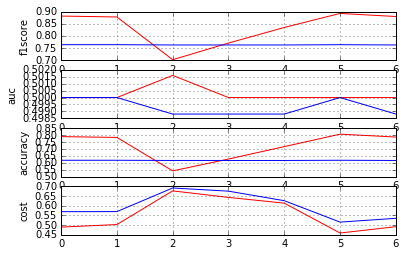

iteration 0
training cost 0.553674
validation cost 0.597267
time(in minutes) for 1 epoch 25.991902
remaining time(in minutes) 2573.198331


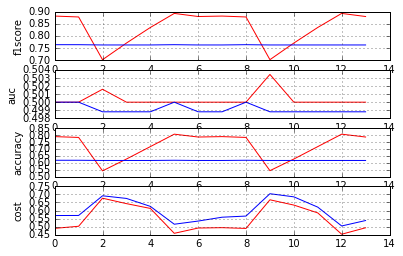

iteration 1
training cost 0.545161
validation cost 0.596748
time(in minutes) for 1 epoch 25.248413
remaining time(in minutes) 2474.344458


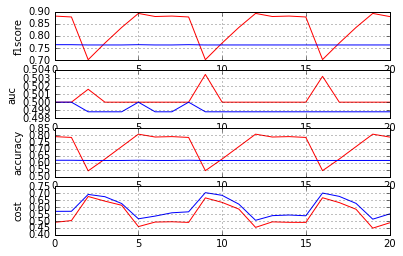

iteration 2
training cost 0.542524
validation cost 0.592586
time(in minutes) for 1 epoch 25.082464
remaining time(in minutes) 2432.998962


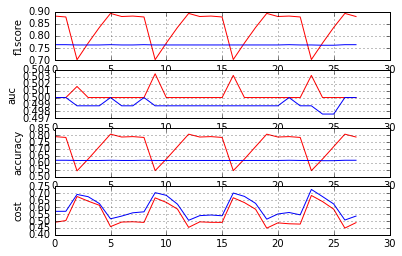

iteration 3
training cost 0.543010
validation cost 0.595962
time(in minutes) for 1 epoch 25.016280
remaining time(in minutes) 2401.562838


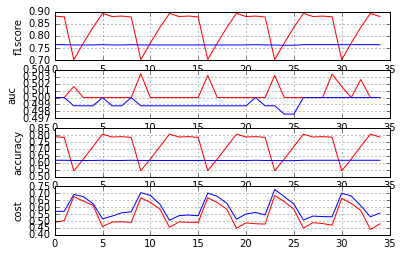

iteration 4
training cost 0.533362
validation cost 0.591101
time(in minutes) for 1 epoch 24.970455
remaining time(in minutes) 2372.193271


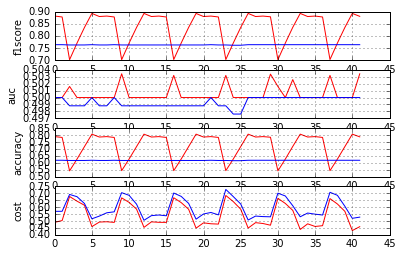

iteration 5
training cost 0.523935
validation cost 0.590710
time(in minutes) for 1 epoch 25.358104
remaining time(in minutes) 2383.661756


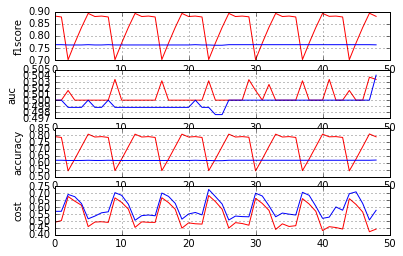

iteration 6
training cost 0.514448
validation cost 0.613450
time(in minutes) for 1 epoch 25.072888
remaining time(in minutes) 2331.778545


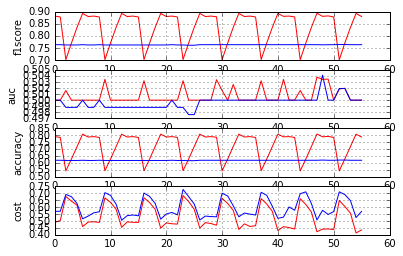

iteration 7
training cost 0.505180
validation cost 0.607718
time(in minutes) for 1 epoch 24.955178
remaining time(in minutes) 2295.876407


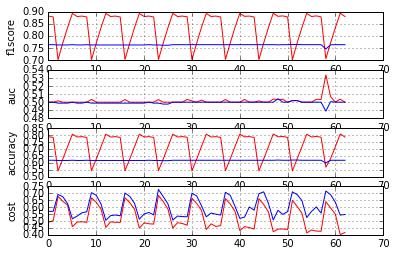

iteration 8
training cost 0.493029
validation cost 0.612249
time(in minutes) for 1 epoch 25.258183
remaining time(in minutes) 2298.494621


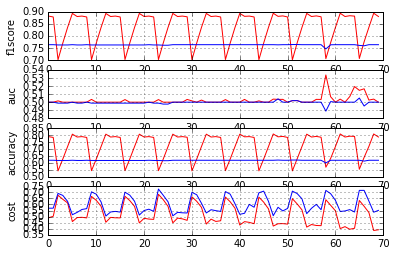

iteration 9
training cost 0.475480
validation cost 0.606251
time(in minutes) for 1 epoch 25.130429
remaining time(in minutes) 2261.738629


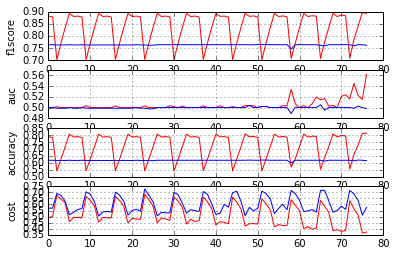

iteration 10
training cost 0.458228
validation cost 0.610115
time(in minutes) for 1 epoch 25.174485
remaining time(in minutes) 2240.529124


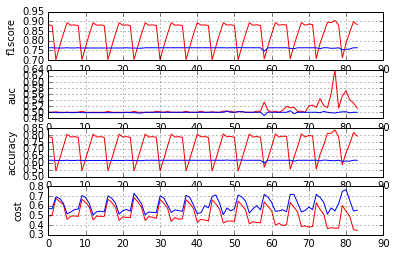

iteration 11
training cost 0.438527
validation cost 0.632989
time(in minutes) for 1 epoch 25.102389
remaining time(in minutes) 2209.010200


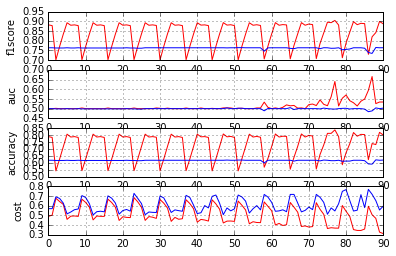

iteration 12
training cost 0.416378
validation cost 0.654669
time(in minutes) for 1 epoch 25.224345
remaining time(in minutes) 2194.518055


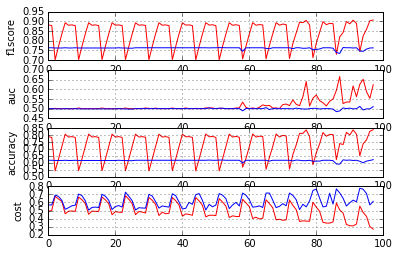

iteration 13
training cost 0.381863
validation cost 0.666907
time(in minutes) for 1 epoch 25.177511
remaining time(in minutes) 2165.265989


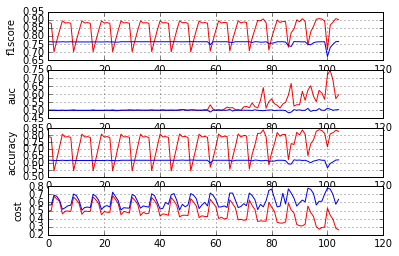

iteration 14
training cost 0.356149
validation cost 0.682200
time(in minutes) for 1 epoch 25.199728
remaining time(in minutes) 2141.976877


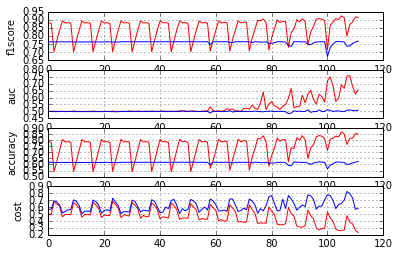

iteration 15
training cost 0.321209
validation cost 0.693879
time(in minutes) for 1 epoch 25.376361
remaining time(in minutes) 2131.614299


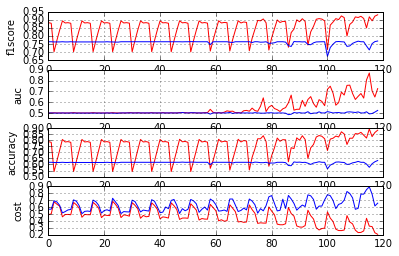

iteration 16
training cost 0.286847
validation cost 0.767904
time(in minutes) for 1 epoch 25.084910
remaining time(in minutes) 2082.047545


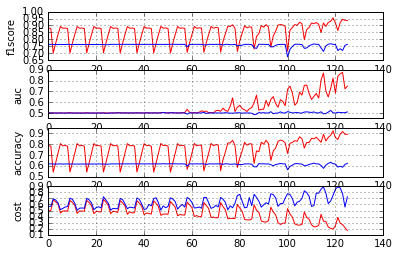

iteration 17
training cost 0.254040
validation cost 0.774964
time(in minutes) for 1 epoch 24.932671
remaining time(in minutes) 2044.479034


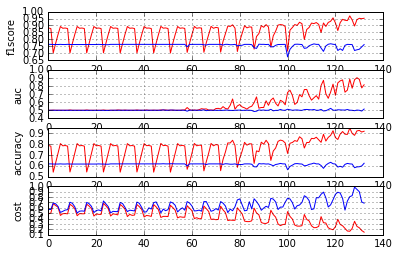

iteration 18
training cost 0.221144
validation cost 0.836510
time(in minutes) for 1 epoch 25.075559
remaining time(in minutes) 2031.120299


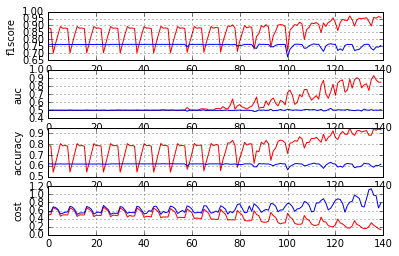

iteration 19
training cost 0.195801
validation cost 0.934571
time(in minutes) for 1 epoch 25.251107
remaining time(in minutes) 2020.088564


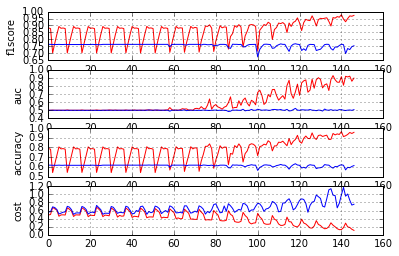

iteration 20
training cost 0.174345
validation cost 0.924556
time(in minutes) for 1 epoch 25.076115
remaining time(in minutes) 1981.013110


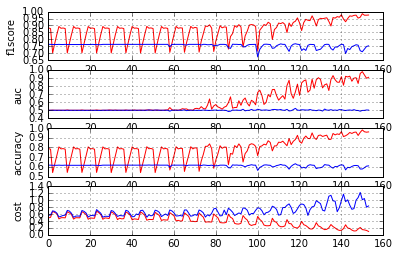

iteration 21
training cost 0.143884
validation cost 0.997624
time(in minutes) for 1 epoch 25.029349
remaining time(in minutes) 1952.289218


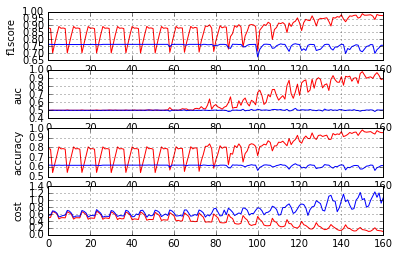

iteration 22
training cost 0.130277
validation cost 1.089564
time(in minutes) for 1 epoch 25.232913
remaining time(in minutes) 1942.934327


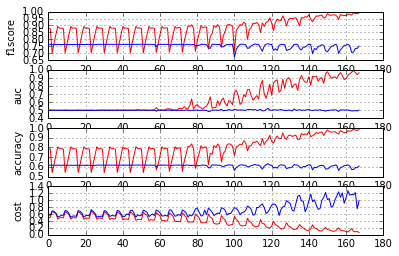

iteration 23
training cost 0.105888
validation cost 1.098769
time(in minutes) for 1 epoch 25.416608
remaining time(in minutes) 1931.662233


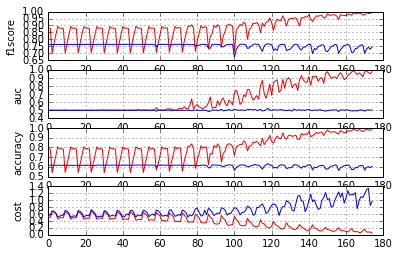

iteration 24
training cost 0.091575
validation cost 1.117066
time(in minutes) for 1 epoch 25.185114
remaining time(in minutes) 1888.883583


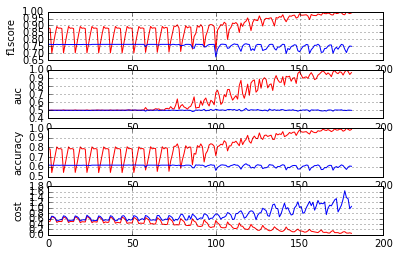

iteration 25
training cost 0.077831
validation cost 1.256203
time(in minutes) for 1 epoch 24.991401
remaining time(in minutes) 1849.363657


In [ ]:
epochs =  100
# train_para and vali_para are storing f1score,auc,accuracy for 
# train and validation set.
train_para = []
vali_para = []
now_time = time.time()
for itera in range(0, epochs):
    # iterate over 5 files and train except last 5 files
    for index in range(0, len(file_dir)-5*2, 5*2):
        # use 5 files starting from index as training files
        train_files = file_dir[index:index+5*2]
        for file_ in train_files:
            data_processing(file_)

        train_batch = np.zeros((340*2,3260,57),dtype=np.float32)
        train_target = np.zeros(0)

        current_i = 0
        for i in range(len(inde_featuress)):
            file_len = inde_featuress[i].shape[0]
            train_target = np.append(train_target,target_valuess[i])
            for j in range(file_len):
                train_batch[current_i+j] = inde_featuress[i][j]
            current_i += file_len
            
        train_batch = train_batch[:,:,:-1]
        #train_target = np.reshape(train_target, (train_target.shape[0],1))
        # reset the values to be used in next call of either val or train set
        inde_featuress = []
        target_valuess = []        
        # collect values to form a list to reduce the parameters to be passed
        indices = np.random.permutation(340*2)
        train_data = [train_batch[indices], train_target[indices]]
        
        # evaluate performance
        train_eval(train_data, val_data)
    
    t_para = np.asarray(train_para)
    v_para = np.asarray(vali_para)
    
    plot_parameters(t_para, v_para)
    
    time_taken = (time.time()-now_time)/60.0
    print "iteration %d"%itera
    print "training cost %f"%np.mean(t_para[-7:,-1])
    print "validation cost %f"%np.mean(v_para[-7:,-1])
    print "time(in minutes) for 1 epoch %f"%(time_taken)
    print "remaining time(in minutes) %f"%((time_taken)*(epochs-1-itera))
    now_time = time.time()